## Drosophila MultiVariate Analysis

Done by : Amir MAHMOUDI & Elisabeth DAO

The purpose of this project is to analyse the drosophila's circadian rythm with the mutation a gene we have different genotype for each population of drosophila. We observe them during 5 days on different lighting setup :
- Regime 1 : 16 hours of light 8 hours of darkness
- Regime 2 : 12 hours of light 12 hours of darkness
- Regime 3 : 16 hours of light 8 hours of darkness (using a red light)

The different features we have are : 
- Bin i : representing a period of 30 min of observation the value assigned at each bin is how many times the drosphila crossed the beam (to observe the activity), we thus have 48 bin per day so 240 in total
- refMC : the matricule for each drosophila
- R : the regime used for the experiment
- genotype : the genotype of the individual

This experiment is done on the same temperature and all the drosphilas are males

In [2]:
#Lib import
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
#Load data
df=pd.read_csv('Table_data_total.csv',sep=';',header=0)

### Get average day and average drosophila profile

In [4]:
for i in range(1,49):#since we repeat the same experiment on 5 days we will avg the results to obtain an avg day type
    str_='avg_bin_'+str(i)
    str_list=[]
    for j in range(5):
        str_list.append('Bin '+str(i+j*48))
    df[str_]=df[str_list].mean(axis=1)

avg_df=df.drop(df.columns[:240],axis=1)

In [5]:
df_genotype = avg_df.drop(['date','refMC'],axis=1)
df_genotype = df_genotype.groupby(['genotype','R']).mean()
df_genotype.head(5)

avg_bin_1  avg_bin_2  avg_bin_3  avg_bin_4  avg_bin_5  \
genotype            R                                                          
;;cry^02            1  11.480625   4.486875   2.390000   1.803750   1.390000   
                    2   3.162500   2.279375   1.840625   1.730000   1.447500   
                    3   1.843125   1.011875   0.792500   0.690000   0.422500   
;;ort^1, HisCl1^134 1  18.586667   8.475556   4.520635   3.544762   2.851429   
                    2   9.405079   5.965714   4.426667   4.144127   3.836190   

                       avg_bin_6  avg_bin_7  avg_bin_8  avg_bin_9  avg_bin_10  \
genotype            R                                                           
;;cry^02            1   1.426875   1.719375   1.556875   2.118750    2.329375   
                    2   1.295000   1.783750   1.560000   1.931875    1.915000   
                    3   0.607500   0.430000   0.561250   0.661875    0.868750   
;;ort^1, HisCl1^134 1   3.401905   3.522540   3.419683   4.084444    4.606349   
                    2   4.102222   4.081905   5.151111   5.010159    5.429206   

                       ...  avg_bin_39  avg_bin_40  avg_bin_41  avg_bin_42  \
genotype            R  ...                                                   
;;cry^02            1  ...   16.915625   18.660625   21.076250   23.388125   
                    2  ...   14.926250   17.169375   18.591250   20.349375   
                    3  ...   18.231875   19.810000   21.394375   22.965000   
;;ort^1, HisCl1^134 1  ...   21.073016   25.406984   30.648889   34.556825   
                    2  ...   19.313016   21.776508   25.192381   27.887619   

                       avg_bin_43  avg_bin_44  avg_bin_45  avg_bin_46  \
genotype            R                                                   
;;cry^02            1   26.078750   29.015625   31.191250   32.556875   
                    2   22.558125   44.756875   17.173125    9.003125   
                    3   23.669375   24.790000   25.664375   26.298750   
;;ort^1, HisCl1^134 1   36.167619   35.237460   31.133968   25.890159   
                    2   32.138413   38.913651   34.935238   28.227302   

                       avg_bin_47  avg_bin_48  
genotype            R                          
;;cry^02            1   33.746875   60.708750  
                    2    5.310625    3.631875  
                    3   27.506250   25.600625  
;;ort^1, HisCl1^134 1   20.340952   35.067302  
                    2   18.557460   12.162540  

[5 rows x 48 columns]

### Visualisation

In [6]:
def color_grade_bar(regime):
    color=[]
    if regime==1 or regime==3:
        dark=8
    else:
        dark=12

    for i in range(48):
        if i<dark or i>=48-dark:
            color.append('#000000')
        else:
            if regime==3:
                color.append('#FF0000')
            else:
                color.append('#808080')
    
    return color

"""def plot_bars(genotype,regime,activity):
    day=range(48)
    color=color_grade_bar(regime)
    plt.figure(figsize=(5,2))
    plt.bar(day,activity,color=color)
    plt.xlabel('Bin')
    plt.ylabel('beam crosses/30 min')
    plt.title('Regime '+str(regime)+' for Genotype :'+genotype)
    plt.show()"""

"def plot_bars(genotype,regime,activity):\n    day=range(48)\n    color=color_grade_bar(regime)\n    plt.figure(figsize=(5,2))\n    plt.bar(day,activity,color=color)\n    plt.xlabel('Bin')\n    plt.ylabel('beam crosses/30 min')\n    plt.title('Regime '+str(regime)+' for Genotype :'+genotype)\n    plt.show()"

In [7]:
def multiplot_bars(genotype,regime,activity,nrow,ncol):
    """
    Plot multiple circadian activity bars for each genotype and regime given
    """
    _,ax=plt.subplots(nrow, ncol,figsize=(20,10))
    count=0
    day=range(48)
    for r in range(nrow):
        for c in range(ncol):
            color=color_grade_bar(regime[count])
            ax[r,c].bar(day,activity[count],color=color)
            ax[r,c].set_xlabel('Bin')
            ax[r,c].set_ylabel('beam crosses/30 min')
            ax[r,c].set_title('Regime '+str(regime[count])+' for Genotype :'+genotype[count])
            count+=1
    plt.show()

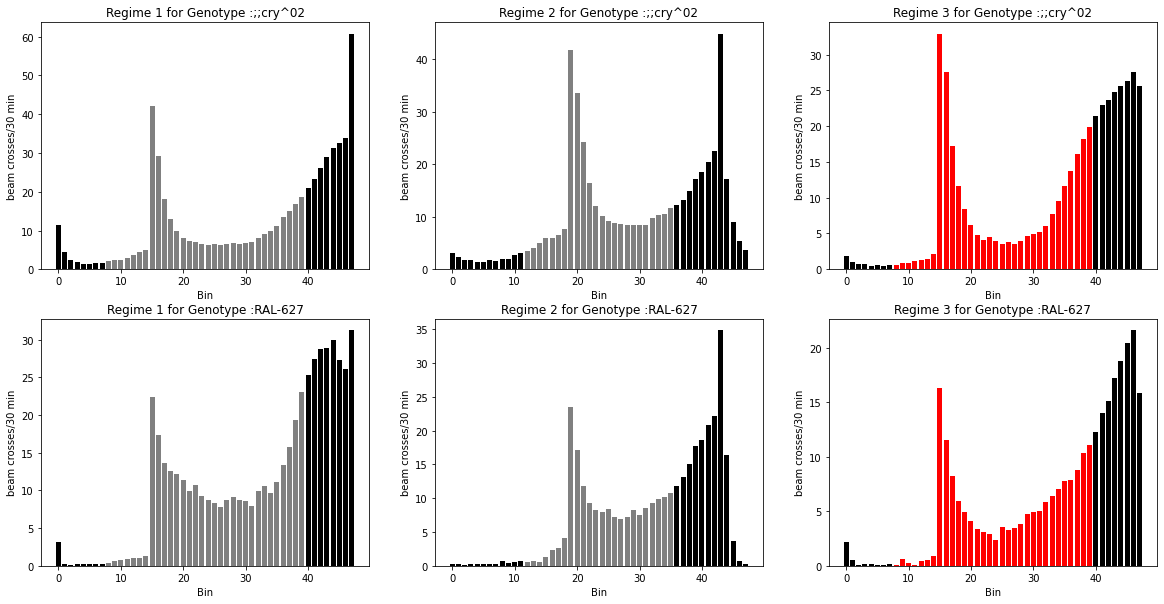

In [8]:
genotype=[]
regime=[]
activity=[]
#to_plot=[(0,1),(39,40),(392,393),(133,134)] #index of genotype and regime to plot
to_plot=[(0,1),(1,2),(2,3),(390,391),(391,392),(392,393)]
for lb,rb in to_plot:
    info,data=next(df_genotype[lb:rb].iterrows())
    genotype.append(info[0])
    regime.append(info[1])
    activity.append(data)

multiplot_bars(genotype,regime,activity,2,3)

**Observation**
Regarding the graph we obtain we see here for the genotype : ;;cry^02 they are sensible to the blue light the drosphila tends to be more active in regime 1 and 2 with a peak during light time of 41~43 which is different in regime 3 the peak is only at 33. In all of them, we observe an "inactivity" during the morning between 00AM and 4AM for R1 and R3 and until 6AM for R2. Since the dark time is longer in R2 the day peak activity is delayed from 8AM for R1 to 9AM for R2. Also the night peak is sooner in R2 with a smoother decrease of activity during the night. The increase of activity during the afternoon is very smooth and common for the 3 regimes.

We have a similar observation for the other genotype but its activity is less.

Let's plot the percentage of light on activity for each genotype and each regime

In [9]:
def percent_light_activity(df):
    R_1=[]
    R_2=[]
    R_3=[]
    for info,data in df.iterrows():
        if info[1]==1 or info[1]==3:
            dark=8
        else:
            dark=12

        if data.sum()>0:
            avg_light_activity=100*data[dark:48-dark].sum()/data.sum()
        else: 
            avg_light_activity=0

        if info[1]==1:
            R_1.append((info[0],avg_light_activity))
        elif info[1]==2:
            R_2.append((info[0],avg_light_activity))
        elif info[1]==3:
            R_3.append((info[0],avg_light_activity))
    
    return R_1,R_2,R_3

In [10]:
R_1,R_2,R_3=percent_light_activity(df_genotype)

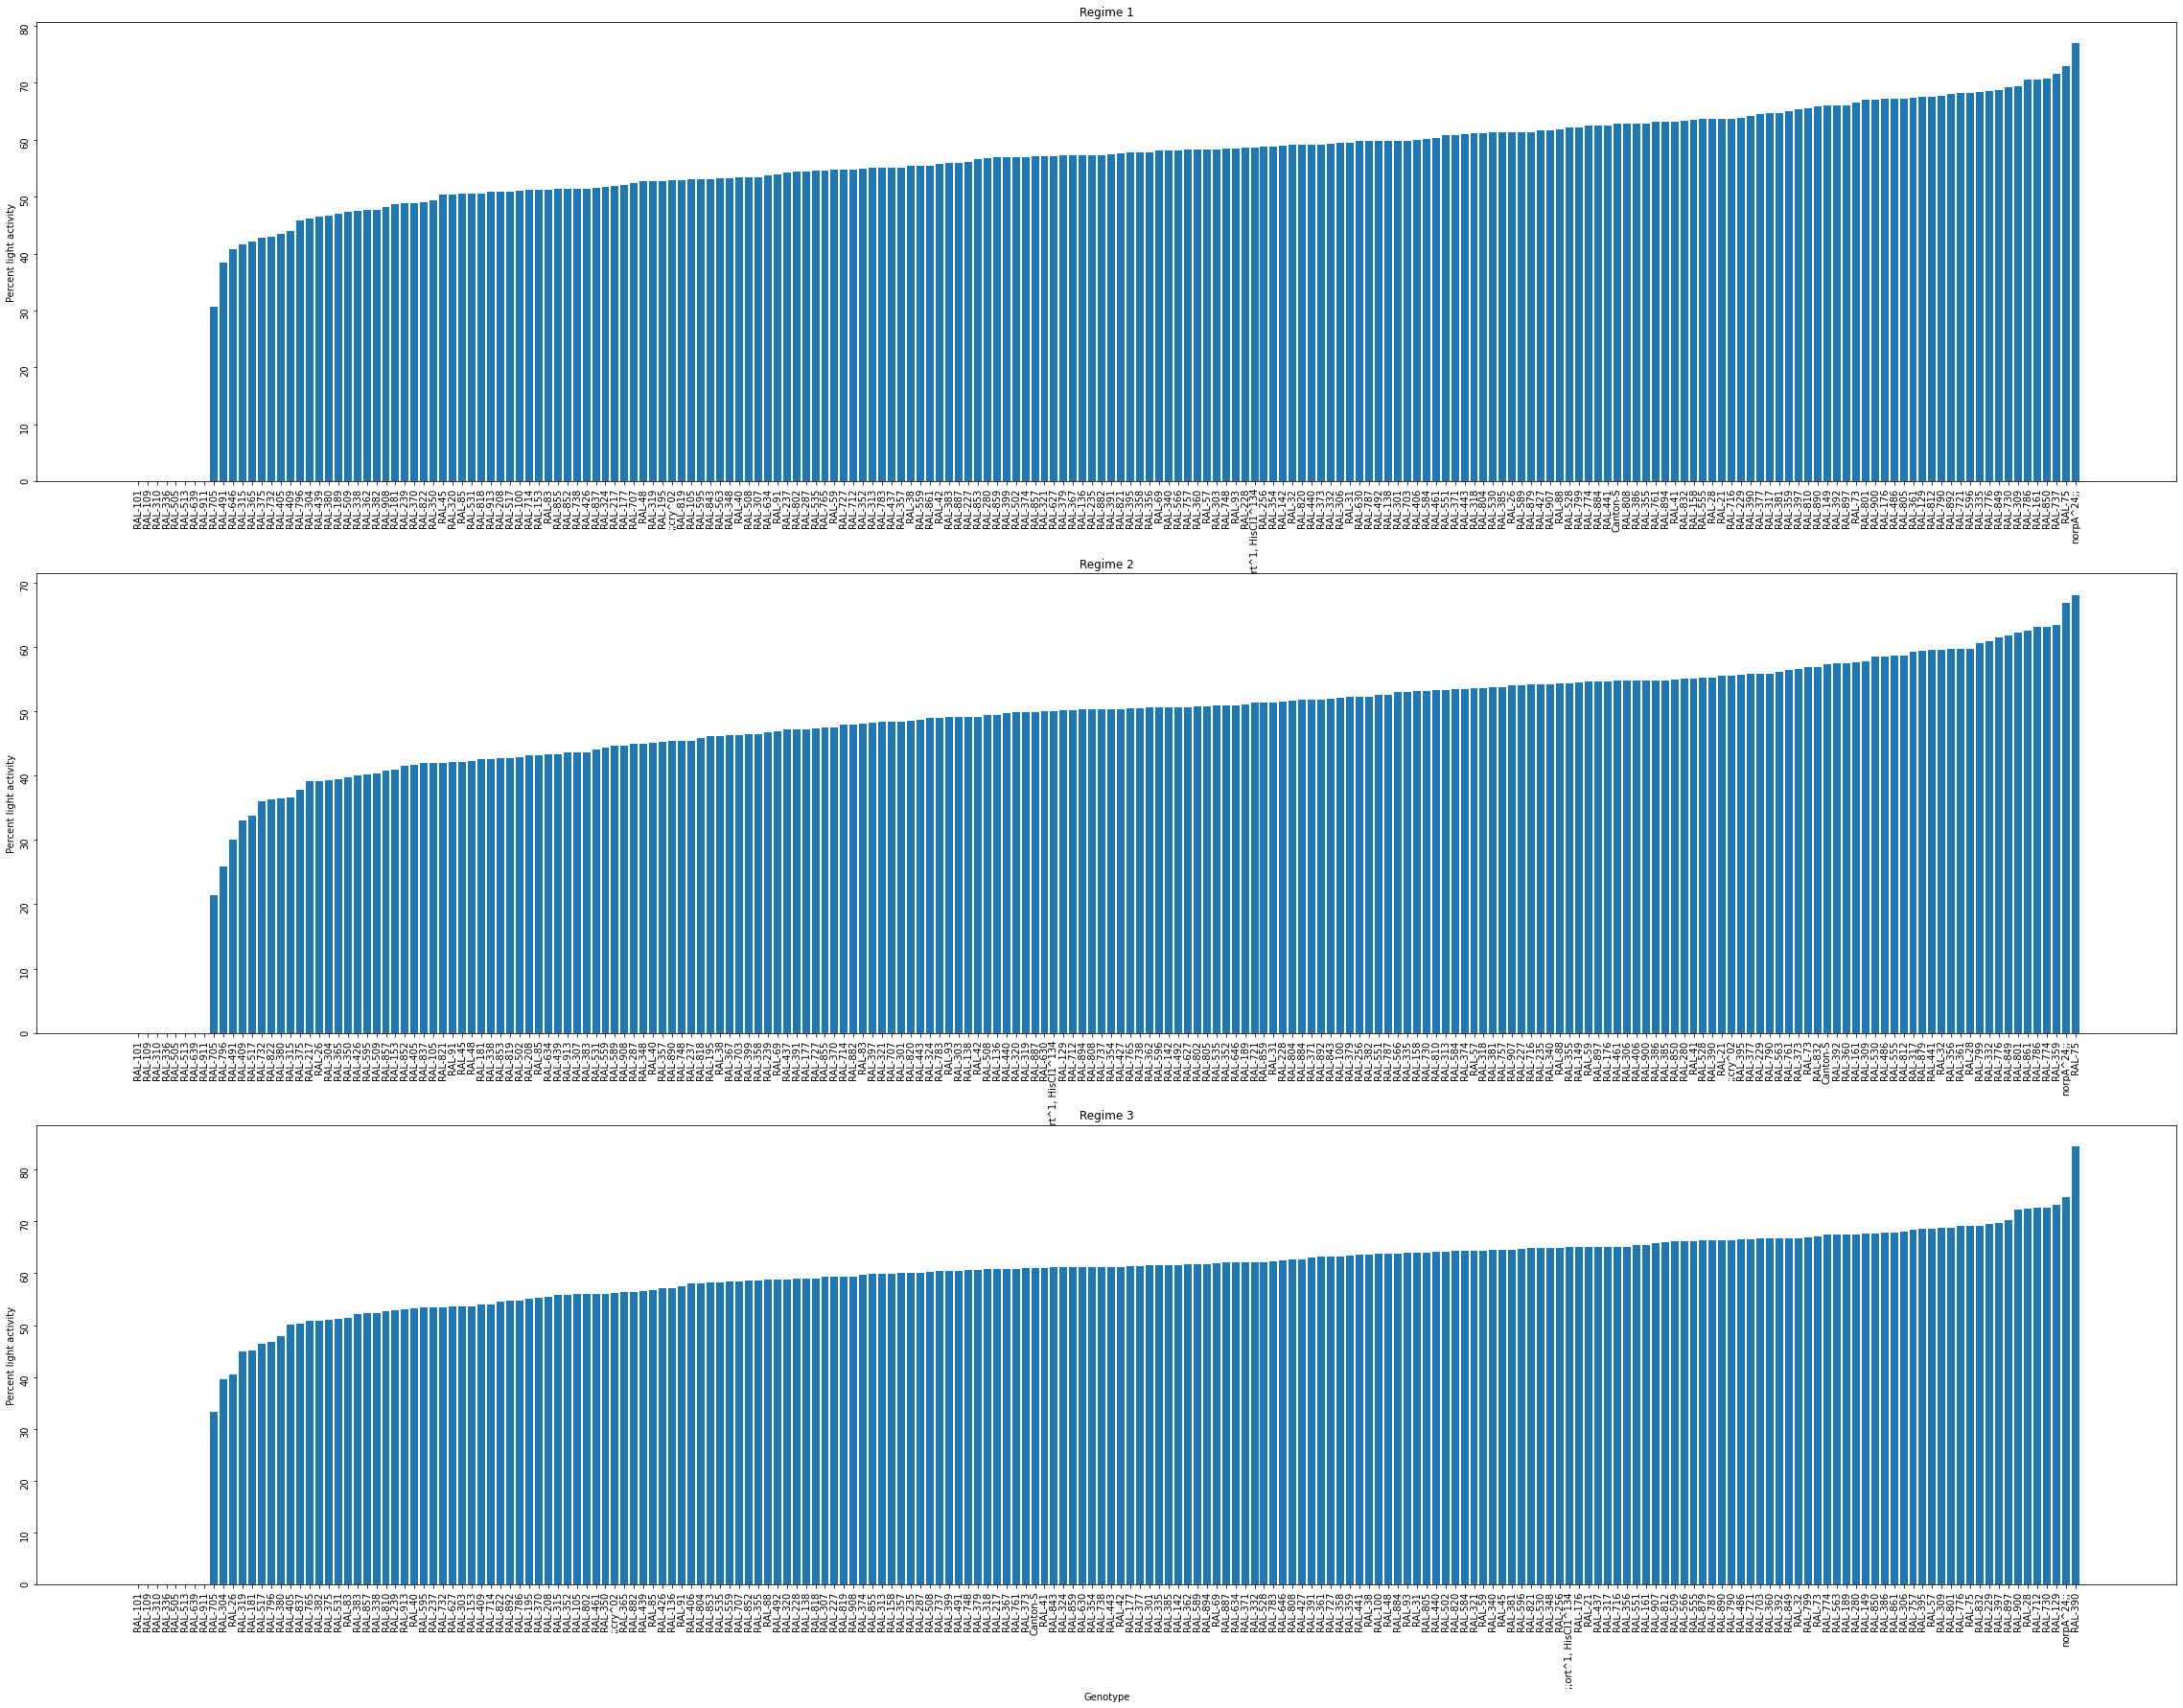

In [11]:
fig,ax=plt.subplots(3,1,figsize=(40,30))
ax[0].bar(*zip(*sorted(R_1, key=lambda tup: tup[1])))
ax[1].bar(*zip(*sorted(R_2, key=lambda tup: tup[1])))
ax[2].bar(*zip(*sorted(R_3, key=lambda tup: tup[1])))
for i in range(3):
    ax[i].tick_params(labelrotation=90)
    ax[i].set_xlabel('Genotype')
    ax[i].set_ylabel('Percent light activity')
    ax[i].set_title('Regime '+str(i+1))
plt.show()

**If you can not see clearly this graph** : open the Percent_light_activity.png to see clearly the labels and values

**Observation** : We observe here for the regime 2 we have less percent of light activity since the dark period is longer (12 hours instead of 8 for the others). Also comparing the plot for the regime 1 and 3 we have more or less a similar light activity curve but the genotype are not in the same order for instance : the ;;ort^1, HisCl1^134 genotype has a 59% of activity done during light for the regime 1 and 62% for the regime 3.

### Create 3 dataframe for each regime

Because the standard scaler we will use need to be done separately on each regime

In [12]:
R_1=[]
R_2=[]
R_3=[]
for info,data in df_genotype.iterrows():
    data=list(data)
    data.append(info[0])
    if info[1]==1:
        R_1.append(data)
    elif info[1]==2:
        R_2.append(data)
    elif info[1]==3:
        R_3.append(data)

df_R1=pd.DataFrame(R_1,columns=list(df_genotype.columns)+['genotype'])
df_R2=pd.DataFrame(R_2,columns=df_R1.columns)
df_R3=pd.DataFrame(R_3,columns=df_R1.columns)

In [13]:
df_R1.head(5)

,avg_bin_1,avg_bin_2,avg_bin_3,avg_bin_4,avg_bin_5,avg_bin_6,avg_bin_7,avg_bin_8,avg_bin_9,avg_bin_10,...,avg_bin_40,avg_bin_41,avg_bin_42,avg_bin_43,avg_bin_44,avg_bin_45,avg_bin_46,avg_bin_47,avg_bin_48,genotype
0,11.480625,4.486875,2.390000,1.803750,1.390000,1.426875,1.719375,1.556875,2.118750,2.329375,...,18.660625,21.076250,23.388125,26.078750,29.015625,31.191250,32.556875,33.746875,60.708750,;;cry^02
1,18.586667,8.475556,4.520635,3.544762,2.851429,3.401905,3.522540,3.419683,4.084444,4.606349,...,25.406984,30.648889,34.556825,36.167619,35.237460,31.133968,25.890159,20.340952,35.067302,";;ort^1, HisCl1^134"
2,1.955625,1.443750,1.376250,1.457500,1.267500,1.549375,1.635625,2.364375,2.096875,2.503750,...,29.790625,33.841875,36.169375,38.861250,40.406250,41.191250,40.766875,39.198750,32.450625,Canton-S
3,0.287500,0.793750,0.962500,1.187500,1.056250,1.312500,0.900000,1.443750,1.475000,1.112500,...,37.331250,46.337500,55.100000,54.937500,54.287500,45.056250,35.593750,25.225000,15.293750,RAL-100
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,RAL-101


### PCA Analysis

We will first apply a PCA on the df_genotype to observe if have clusters between the bins. PCA is effected by scale so we need to scale the features in our data before applying PCA. StandardScaler will standardize the dataset’s features onto unit scale (mean = 0 and variance = 1) which is a requirement for the optimal performance of many machine learning algorithms.

In [96]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [76]:
def PCA_plot(df,n_components,R):
    """
    Plot the PCA of the dataframe given
    """
    df_scaled=StandardScaler().fit_transform(df)
    pca=PCA(n_components=n_components)
    pca.fit(df_scaled)
    df_pca=pca.transform(df_scaled)
    explained_variance_pca=pca.explained_variance_ratio_
    pca_comp=abs(pca.components_)
    if n_components==2:
        plt.scatter(df_pca[:,0],df_pca[:,1],c=df[df.columns[-1]])
        plt.title('PCA on Regime'+str(R))
        plt.xlabel('PCA 1')
        plt.ylabel('PCA 2')
        plt.show()
    
    return explained_variance_pca,pca_comp


First we will plot the explained variance ratio for each regime with a number of components of 15 since we tried for all 48 features but the last were closely equal to 0

In [16]:
exp_var_pca_R1,pca_comp_R1=PCA_plot(df_R1.loc[:,df_R1.columns!='genotype'],15,1)
exp_var_pca_R2,pca_comp_R2=PCA_plot(df_R2.loc[:,df_R2.columns!='genotype'],15,2)
exp_var_pca_R3,pca_comp_R3=PCA_plot(df_R3.loc[:,df_R3.columns!='genotype'],15,3)

Text(0.5, 0, 'Principal component index')

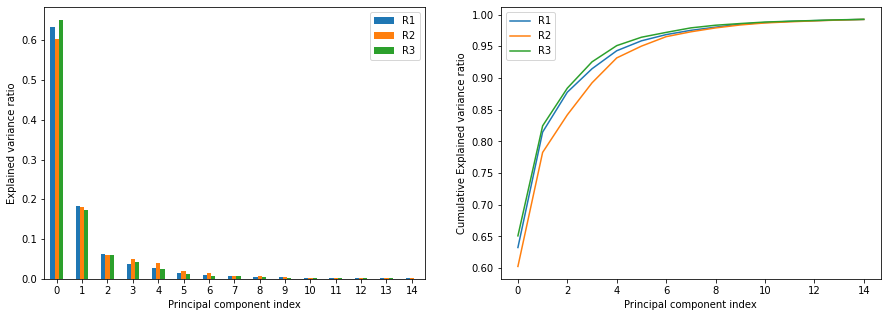

In [17]:
"""
Individual Explained Variance Ratio for each PCA & Cumulative Explained Variance Ratio
"""
df_exp_var_pca=pd.DataFrame(np.array([exp_var_pca_R1,exp_var_pca_R2,exp_var_pca_R3]).T,columns=['R1','R2','R3'])
df_cum_exp_var_pca=df_exp_var_pca.cumsum()

fig,ax=plt.subplots(1,2,figsize=(15,5))
el=df_exp_var_pca.plot(kind='bar',ax=ax[0],rot=0)
el.set_ylabel('Explained variance ratio')
el.set_xlabel('Principal component index')
el=df_cum_exp_var_pca.plot(ax=ax[1],rot=0)
el.set_ylabel('Cumulative Explained variance ratio')
el.set_xlabel('Principal component index')

**Observation**
We see in the figure above that the first 2 components explain between 83% and 78% of the explained variance ratio. Also, from the pca component index 4 and onwards the ratio is less than 0.06 and near 0 from the index 8. Comparing the cumulative ratio, the third regime is the best explained by the pca components overall the least is actually the regime 2. The first pca component is the one explaining the most with a ratio around 0.6 and 0.63 for all regimes.

For the plot of the PCA we will use only the 2 first components but the five first components to analyse and see if they are some clusters between the bins

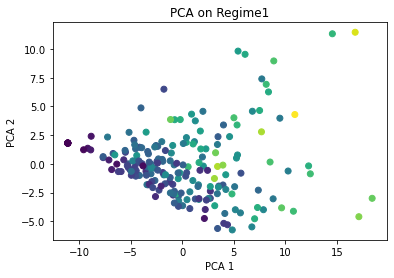

In [77]:
_,_=PCA_plot(df_R1.loc[:,df_R1.columns!='genotype'],2,1)

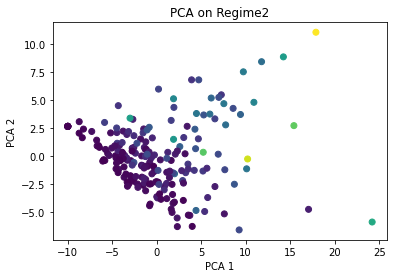

In [19]:
_,_=PCA_plot(df_R2.loc[:,df_R2.columns!='genotype'],2,2)

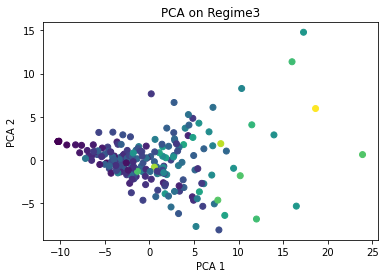

In [20]:
_,_=PCA_plot(df_R3.loc[:,df_R3.columns!='genotype'],2,3)

### Genotype Clustering

In [122]:
def get_cluster_labels(df2pca,df,n_clusters):
    """
    Get the cluster labels for the dataframe given
    """
    temp=df.copy()
    df_scaled=StandardScaler().fit_transform(df2pca)
    pca=PCA(n_components=2)
    pca.fit(df_scaled)
    df_pca=pca.transform(df_scaled)
    kmeans=KMeans(n_clusters=n_clusters,random_state=0).fit(df_pca)
    labels=kmeans.labels_
    temp["label"]=labels
    label_count=temp[['genotype','label']].groupby(['label']).agg(['count'])

    #create label dictionary with genotype as values and label as keys
    label_dict={}
    for i in range(4):
        label_dict[i]=[]
    for i in range(len(df)):
        label_dict[temp.iloc[i]['label']].append(temp.iloc[i]['genotype'])

    return label_count.to_numpy(),label_dict,df_pca,labels

In [123]:
count_R1,label_dict_R1,pca_df_R1,labels_R1=get_cluster_labels(df_R1.loc[:,df_R1.columns!='genotype'],df_R1,4)
count_R2,label_dict_R2,pca_df_R2,labels_R2=get_cluster_labels(df_R2.loc[:,df_R2.columns!='genotype'],df_R2,4)
count_R3,label_dict_R3,pca_df_R3,labels_R3=get_cluster_labels(df_R3.loc[:,df_R3.columns!='genotype'],df_R3,4)

**Nota Bene:** the label dicts contains the cluster associated to each genotype

In [ ]:
label_dict_R1

Text(0, 0.5, 'Genotype Count')

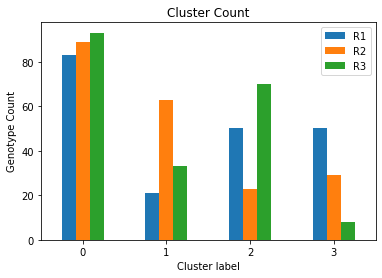

In [137]:
pd.DataFrame(np.concatenate((count_R1,count_R2,count_R3),axis=1),columns=['R1','R2','R3']).plot(kind='bar',rot=0)
plt.title('Cluster Count')
plt.xlabel('Cluster label')
plt.ylabel('Genotype Count')

**Observation** We see here the count of genotype for each cluster and each regime. The cluster 0 is the more common with an overall of 80 on each regime. Cluster 1 is more present for the R2 as the Cluster 2 is for R3.

Text(0, 0.5, 'PCA 2')

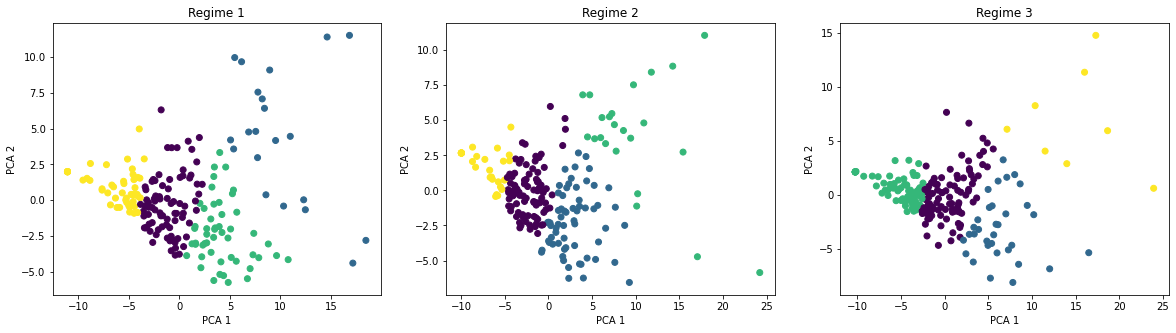

In [135]:
fig,ax=plt.subplots(1,3,figsize=(20,5))
ax[0].scatter(pca_df_R1[:,0],pca_df_R1[:,1],c=labels_R1)
ax[0].set_title('Regime 1')
ax[0].set_xlabel('PCA 1')
ax[0].set_ylabel('PCA 2')
ax[1].scatter(pca_df_R2[:,0],pca_df_R2[:,1],c=labels_R2)
ax[1].set_title('Regime 2')
ax[1].set_xlabel('PCA 1')
ax[1].set_ylabel('PCA 2')
ax[2].scatter(pca_df_R3[:,0],pca_df_R3[:,1],c=labels_R3)
ax[2].set_title('Regime 3')
ax[2].set_xlabel('PCA 1')
ax[2].set_ylabel('PCA 2')

**Observation** Here we have the plot of the genotypes along PCA1 and PCA2 and the clusters asssociated we have a cluster for the "outliers" then we have a big crowd divided in 3 clusters.

### Bin Clustering based on time of the day

In [21]:
def color_grade_point():
    """
    set the color of the grade point for specific time of the day
    """
    color=[]
    for i in range(48):
        if i<14:#from midnight to 7am (night)
            color.append('#1B0FFF')#BLUE
        elif i<24:#from 7am to 12pm (morning)
            color.append('#FF0FE4')#PINK
        elif i<34:#from 12pm to 5pm (afternoon)
            color.append('#1AFF25')#GREEN
        elif i<48:#from 5pm to midnight (evening)
            color.append('#FF900F')#ORANGE
    
    return color

In [22]:
_,comp_pca_R1=PCA_plot(df_R1.loc[:,df_R1.columns!='genotype'],5,1)
_,comp_pca_R2=PCA_plot(df_R2.loc[:,df_R2.columns!='genotype'],5,2)
_,comp_pca_R3=PCA_plot(df_R3.loc[:,df_R3.columns!='genotype'],5,3)
df_comp_pca_R1=pd.DataFrame(comp_pca_R1,columns=['bin '+str(i+1) for i in range(48)]).T
df_comp_pca_R1.columns=['pca_'+str(i+1) for i in range(5)]
df_comp_pca_R2=pd.DataFrame(comp_pca_R2,columns=['bin '+str(i+1) for i in range(48)]).T
df_comp_pca_R2.columns=['pca_'+str(i+1) for i in range(5)]
df_comp_pca_R3=pd.DataFrame(comp_pca_R3,columns=['bin '+str(i+1) for i in range(48)]).T
df_comp_pca_R3.columns=['pca_'+str(i+1) for i in range(5)]

<AxesSubplot:title={'center':'\nBin representation w/ PCA 1 & 5 for Regime 3\n'}, xlabel='pca_1', ylabel='pca_5'>

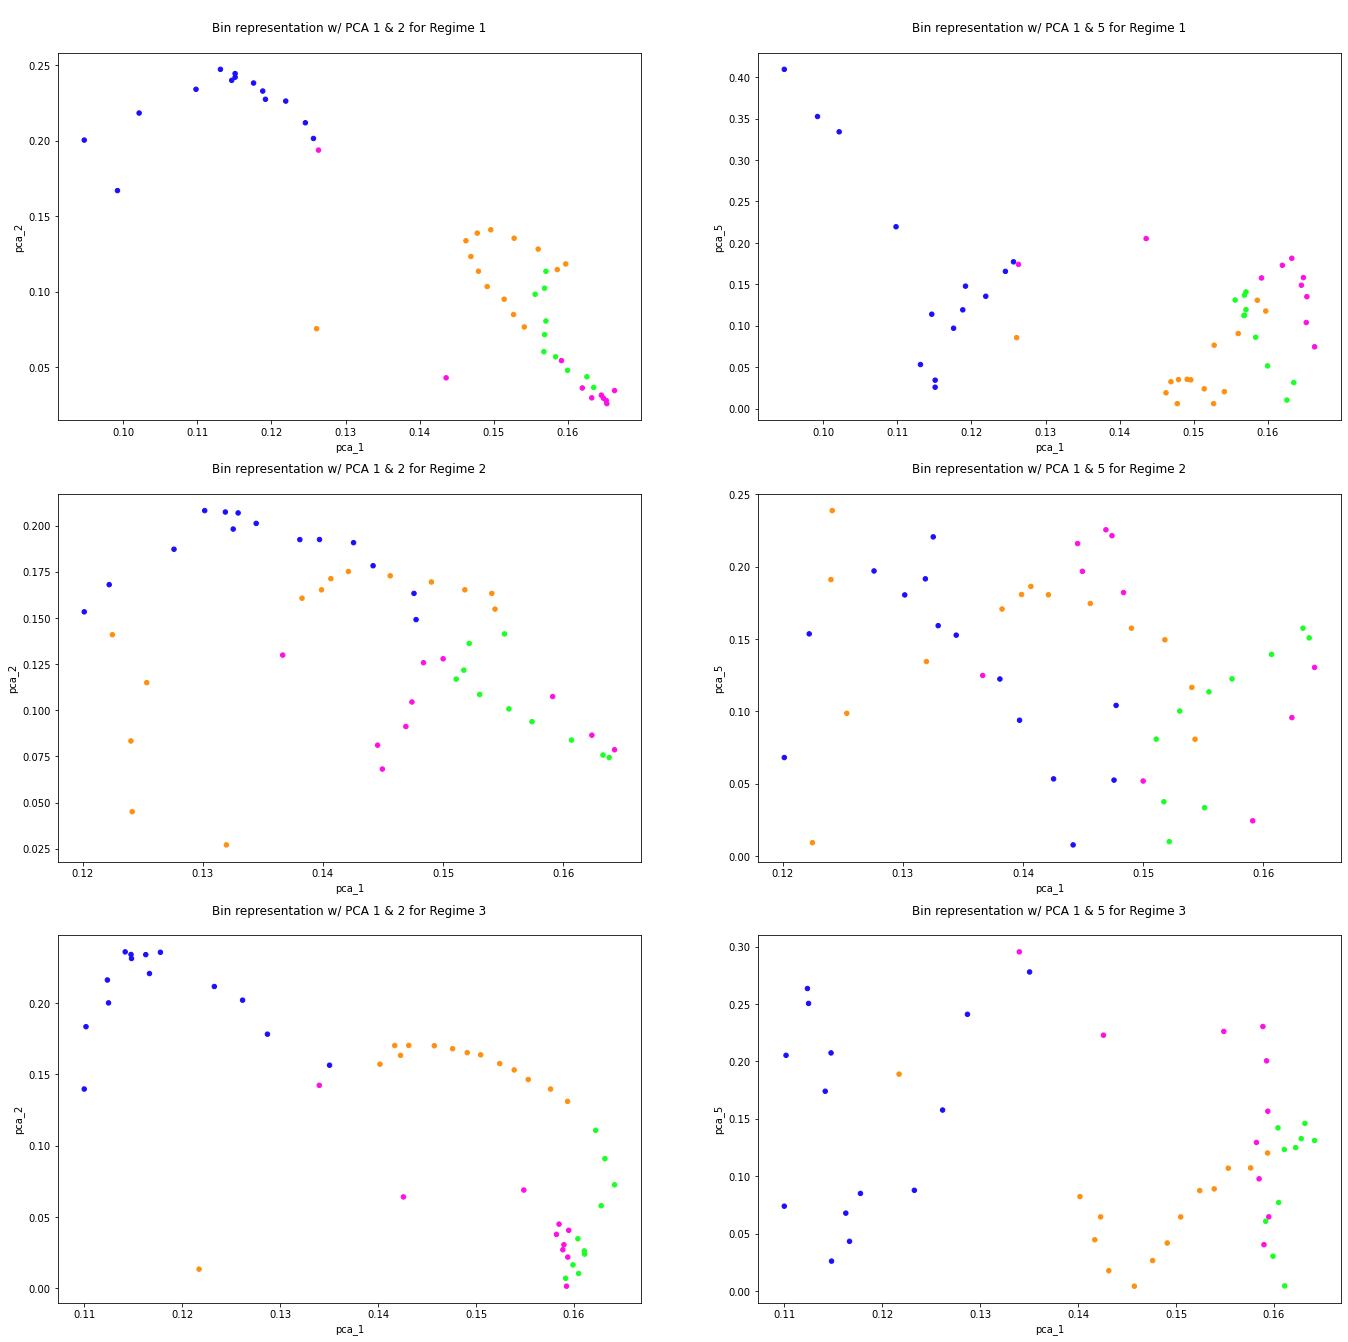

In [27]:
fig,ax=plt.subplots(3,2,figsize=(23,23))
df_comp_pca_R1.plot(kind='scatter',x='pca_1',y='pca_2',color=color_grade_point(),ax=ax[0,0],title='\nBin representation w/ PCA 1 & 2 for Regime 1\n')
df_comp_pca_R1.plot(kind='scatter',x='pca_1',y='pca_5',color=color_grade_point(),ax=ax[0,1],title='\nBin representation w/ PCA 1 & 5 for Regime 1\n')
df_comp_pca_R2.plot(kind='scatter',x='pca_1',y='pca_2',color=color_grade_point(),ax=ax[1,0],title='\nBin representation w/ PCA 1 & 2 for Regime 2\n')
df_comp_pca_R2.plot(kind='scatter',x='pca_1',y='pca_5',color=color_grade_point(),ax=ax[1,1],title='\nBin representation w/ PCA 1 & 5 for Regime 2\n')
df_comp_pca_R3.plot(kind='scatter',x='pca_1',y='pca_2',color=color_grade_point(),ax=ax[2,0],title='\nBin representation w/ PCA 1 & 2 for Regime 3\n')
df_comp_pca_R3.plot(kind='scatter',x='pca_1',y='pca_5',color=color_grade_point(),ax=ax[2,1],title='\nBin representation w/ PCA 1 & 5 for Regime 3\n')

**Observation** : In this graph we plotted the bin values by associating to them a color depending on their time in the day (morning afternoon evening etc...). We tried plotting with various combination of the axis the best one was PCA 1 for x and PCA 2 for y. The cluster are really disctinct for the regime 1 and 3. Not for the regime 2 because the 12-12 hours regime implies a confusion "between the afternoon and evening for instance.

For regime 1 and 3, the pink and green color are really close to each other because it correspond to the morning and afternoon and with the first plot of this notebook we observe a similar profile of activity during those periods.